<a href="https://colab.research.google.com/github/Nuri-Tas/Data-Analysis/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter('ignore')

In [95]:
df = pd.read_csv('/content/data.csv', parse_dates=[0])

df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4549 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4549 non-null   datetime64[ns]
 1   price          4549 non-null   float64       
 2   bedrooms       4549 non-null   float64       
 3   bathrooms      4549 non-null   float64       
 4   sqft_living    4549 non-null   int64         
 5   sqft_lot       4549 non-null   int64         
 6   floors         4549 non-null   float64       
 7   waterfront     4549 non-null   int64         
 8   view           4549 non-null   int64         
 9   condition      4549 non-null   int64         
 10  sqft_above     4549 non-null   int64         
 11  sqft_basement  4549 non-null   int64         
 12  yr_built       4549 non-null   int64         
 13  yr_renovated   4549 non-null   int64         
 14  street         4549 non-null   object        
 15  city           4549 n

In [96]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


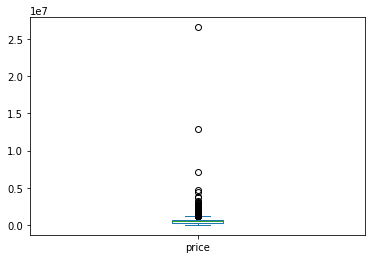

In [97]:
df['price'].plot.box()

In [98]:
cond = df['price'] < 10**3

df = df[~cond]

In [105]:
outliers = df[df['price'] > 0.5*10**7]

outliers

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2286,2014-06-11,7062500.0,5.0,4.5,10040,37325,2.0,1,2,3,7680,2360,1940,2001,4442 95th Ave NE,Bellevue,WA 98004,USA
4346,2014-06-23,12899000.0,3.0,2.5,2190,11394,1.0,0,0,3,1550,640,1956,2001,5426 40th Ave W,Seattle,WA 98199,USA
4350,2014-07-03,26590000.0,3.0,2.0,1180,7793,1.0,0,0,4,1180,0,1992,0,12005 SE 219th Ct,Kent,WA 98031,USA


In [106]:
df.groupby('statezip').mean().loc[outliers['statezip']]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
statezip,,,,,,,,,,,,,
WA 98004,1.372758e+06,3.830986,2.549296,3066.690141,14223.577465,1.457746,0.014085,0.295775,3.450704,2520.070423,546.619718,1971.126761,1093.746479
WA 98199,9.572357e+05,3.388060,2.294776,2204.552239,5170.328358,1.552239,0.000000,0.686567,3.597015,1630.223881,574.328358,1955.477612,1071.850746
WA 98031,6.826135e+05,3.439394,2.117424,1865.590909,10484.969697,1.469697,0.000000,0.000000,3.575758,1631.348485,234.242424,1983.303030,394.500000


In [111]:
df.drop(outliers.index[-2:], inplace=True)

Check null values:

In [113]:
df.isna().any().sum()

0

The percentage of the most frequent 5 values for each column with non-numerical type:

In [115]:
obj_cols = df.columns[-4:]
{col: np.round(df[col].value_counts().iloc[:5].values / len(df) * 100, 1) for col in obj_cols}

{'street': array([0.1, 0.1, 0. , 0. , 0. ]),
 'city': array([34.3,  6.4,  6.2,  5.2,  4.1]),
 'statezip': array([3.3, 3. , 2.9, 2.8, 2.4]),
 'country': array([100.])}

In [116]:
df.drop(['street', 'country'], axis=1, inplace=True)

In [117]:
for col in ['city', 'statezip']:
  df[col] = df[col].astype('category').cat.codes

In [118]:
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
0,2014-05-02,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,36,62
1,2014-05-02,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,35,58
2,2014-05-02,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,18,26


In [119]:
corr = df.corr()['price'].sort_values(ascending=False, key=abs)
corr

price            1.000000
sqft_living      0.697525
sqft_above       0.597172
bathrooms        0.522377
view             0.378629
sqft_basement    0.338806
bedrooms         0.332038
floors           0.255843
waterfront       0.231763
sqft_lot         0.082404
statezip        -0.066362
condition        0.051808
yr_renovated    -0.040625
city             0.029000
yr_built         0.025918
Name: price, dtype: float64

Take the columns with absolute correlation higher than 0.1 as features, and scale them after train-test split:

In [147]:
features = corr[abs(corr) > 0.1].index

features = df.columns.drop('date')
train_len = round(len(df) * 0.8)
train, test = df.iloc[:train_len], df.iloc[train_len:]

# we need the inverse scaler of price later on
for feature in features[::-1]:
  scaler = StandardScaler()
  train[f'scaled_{feature}'] = scaler.fit_transform(train.loc[:, [feature]])
  test[f'scaled_{feature}'] = scaler.transform(test.loc[:, [feature]])

In [149]:
def lstm_dataset(data, lookback):
  x_data = []
  y_data = []

  for i in range(len(data) - lookback):
    x_data.append(data.iloc[i:i+lookback].values)
    y_data.append(data.iloc[i].values)
  
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  return x_data, y_data

In [185]:
scaled_cols =  train.columns[train.columns.str.contains('scaled')]

lookback = 7
x_train, y_train = lstm_dataset(train[scaled_cols], lookback)

In [186]:
x_train.shape

(3632, 7, 15)

In [187]:
def build_model(lookback):

  model = Sequential()
  model.add(LSTM(128, input_shape=x_train.shape[1:], activation='relu', return_sequences=True))
  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1,kernel_regularizer='l1'))

  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
  model.summary()

  return model

model = build_model(lookback)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 7, 128)            73728     
                                                                 
 lstm_27 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [189]:
model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=False)

In [190]:
history = model.history.history

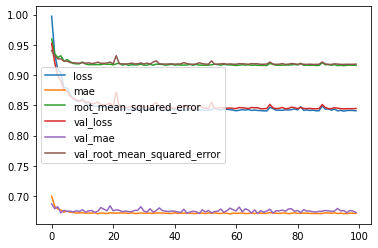

In [191]:
pd.DataFrame(history).plot()

In [192]:
test_concat = pd.concat([train.iloc[-lookback:][scaled_cols], test[scaled_cols]])
x_test, y_test = lstm_dataset(test_concat, lookback)

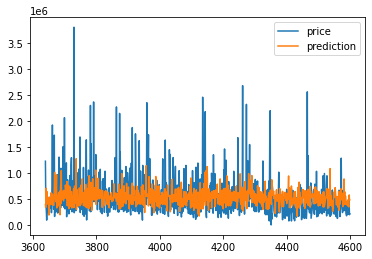

In [193]:
pred = model.predict(x_test)
actual_pred = scaler.inverse_transform(pred)
test['prediction'] = actual_pred
test[['price', 'prediction']].plot()

In [200]:
mae = mean_absolute_error(test['price'], test['prediction'])
mae

273339.23408695497

In [199]:
mape = mean_absolute_percentage_error(test['price'], test['prediction'])
mape

0.7212490272350138

In [198]:
mse = mean_squared_error(test['price'], test['prediction'])
rmse = np.sqrt(mse)
rmse

403019.0051948507